In [1]:
import librosa
import librosa.display
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pylab
from scipy import signal
from tqdm.notebook import tqdm
from glob import glob
import gc

import tensorflow as tf
import keras
from keras import layers, losses
from keras.models import Model, load_model
import keras.backend as K
from keras.activations import leaky_relu
from keras.losses import binary_crossentropy, mean_squared_error

from keras.layers import Input,Conv2D, Layer, UpSampling2D, MaxPooling2D, Dense, Flatten, Lambda, GlobalAveragePooling2D, Conv2DTranspose, Reshape, BatchNormalization, Dropout, ELU, ReLU
from tensorflow.keras.utils import plot_model

import os
import pdb

import ast

c:\Users\GP65\anaconda3\envs\py39\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


## Getting the DataSet

In [2]:
train_paths = glob('D:/Projects/Orpheus_ai/DataSet/Spectrograms/HalfMEL_dbscale/*')[:-100]
test_paths = glob('D:/Projects/Orpheus_ai/DataSet/Spectrograms/HalfMEL_dbscale/*')[-100:]
vqvae = load_model('D:/Projects/Orpheus_ai/DataSet/model_save_logs/Saved Models (Aux)/VQVAE(7K)_basicAux_3e-03recloss',compile=False)
embeddings = vqvae.quantizer.layers[-1].embeddings

BATCH_SIZE = 4
AUTOTUNE = tf.data.experimental.AUTOTUNE
min_level_db = -80 

In [3]:
def get_code_indices(flattened_inputs, embeddings=embeddings):
    # Calculate L2-normalized distance between the inputs and the codes.
    similarity = tf.matmul(flattened_inputs, embeddings) * 2

    embeddings_ssq = tf.reduce_sum(embeddings ** 2, axis=0)
    inputs_ssq = tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
    
    distances = (embeddings_ssq + inputs_ssq)
    distances = (distances - similarity)

    # Derive the indices for minimum distances.
    encoding_indices = tf.argmin(distances, axis=1)
    encoding_indices = tf.reshape(encoding_indices,(32,54))

    return encoding_indices, encoding_indices


def data_loader(path):
    path = bytes.decode(path.numpy())
    spec = tf.cast(np.load(path),tf.float32)
    spec = tf.expand_dims(spec,axis=-1)
    return spec

def normalize(S):
    return np.clip((((S - min_level_db) / -min_level_db)*2.)-1., -1, 1)

def denormalize(S):
    return (((np.clip(S, -1, 1)+1.)/2.) * -min_level_db) + min_level_db



def flatten(S):
    S = tf.expand_dims(S,axis=0)
    encodings = vqvae.encoder(S)
    ## Flatten the encodings
    original_shape = encodings.shape[1:-1]
    encodings_flattened = tf.reshape(encodings,[-1,encodings.shape[-1]])

    return encodings_flattened



# def qunatize(S):
#     S = tf.expand_dims(S,axis=0)
#     encodings = vqvae.encoder(S)
#     ## Flatten the encodings
#     original_shape = encodings.shape[1:-1]
#     encodings_flattened = tf.reshape(encodings,[-1,encodings.shape[-1]])
#     ## Get the indices of the encodings
#     indices = get_code_indices(vqvae.quantizer.layers[-1].embeddings,encodings_flattened)
#     ## Reshape indices into encodings shape
#     indices = tf.reshape(indices,original_shape)
#     return indices,indices


In [4]:
def get_dataset(data_paths):
    dataset = tf.data.Dataset.from_tensor_slices(data_paths)
    dataset = dataset.map(lambda x : tf.py_function(data_loader, [x], [tf.float32]), num_parallel_calls=AUTOTUNE)
    dataset = dataset.map(lambda x : tf.py_function(normalize, [x], [tf.float32]), num_parallel_calls=AUTOTUNE)
    dataset = dataset.map(lambda x : tf.py_function(flatten, [x], [tf.float32]), num_parallel_calls=AUTOTUNE)    
    dataset = dataset.map(lambda x : tf.py_function(get_code_indices, [x], [tf.int64,tf.int64]), num_parallel_calls=AUTOTUNE)    
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.repeat()
    it = dataset.__iter__() #missing line
    
    return it


In [5]:
X_train = get_dataset(train_paths)
X_test = get_dataset(test_paths)
# X_test = np.array([np.expand_dims(normalize(np.load(i)),axis=-1) for i in test_paths])

In [6]:
X_train_array = []
for i in tqdm(range(2000)):
    try:
        for j in next(X_train):
            X_train_array.append(j)
    except:
        pass
    
X_train_array = np.array(X_train_array)
X_train_array = X_train_array.reshape(-1,32,54)

  0%|          | 0/2000 [00:00<?, ?it/s]

## Model Architecture

In [7]:
class PixelConvLayer(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super().__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv2D(**kwargs)

    def build(self, input_shape):
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)
    
class ResidualBlock(keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )
        self.pixel_conv = PixelConvLayer(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return keras.layers.add([inputs, x])



In [8]:
num_residual_blocks = 1
num_pixelcnn_layers = 1
pixelcnn_input_shape = (32, 54)
num_embeddings = 2048

In [9]:
pixelcnn_inputs = keras.Input(shape=pixelcnn_input_shape, dtype=tf.int32)
ohe = tf.one_hot(pixelcnn_inputs, num_embeddings)

x = PixelConvLayer(
    mask_type="A", filters=1024, kernel_size=7, activation="relu", padding="same"
)(ohe)

for _ in range(num_residual_blocks):
    x = ResidualBlock(filters=1024)(x)

for _ in range(num_pixelcnn_layers):
    x = PixelConvLayer(
        mask_type="B",
        filters=1024,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

out = keras.layers.Conv2D(
    filters=num_embeddings, kernel_size=1, strides=1, padding="valid"
)(x)

pixel_cnn = keras.Model(pixelcnn_inputs, out, name="pixel_cnn")
pixel_cnn.summary()

Model: "pixel_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 54)]          0         
                                                                 
 tf.one_hot (TFOpLambda)     (None, 32, 54, 2048)      0         
                                                                 
 pixel_conv_layer (PixelConv  (None, 32, 54, 1024)     102761472 
 Layer)                                                          
                                                                 
 residual_block (ResidualBlo  (None, 32, 54, 1024)     6294016   
 ck)                                                             
                                                                 
 pixel_conv_layer_2 (PixelCo  (None, 32, 54, 1024)     1049600   
 nvLayer)                                                        
                                                         

In [10]:
pixel_cnn.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [11]:
pixel_cnn.load_weights('D:\Projects\Orpheus_ai\DataSet\model_save_logs\Generative Models\PixelCNN2_acc60.h5')

In [12]:
## Get all the samples possible from X_train in an array
## X_train_array = np.array([next(X_train)[0] for i in range(10000)])
## X_train_array = X_train_array.reshape(-1,32,54)

In [13]:
pixel_cnn.fit(X_train_array,X_train_array,
    epochs=100
)

Epoch 1/100
498/498 [==============================] - 2606s 5s/step - loss: 3.7736 - accuracy: 0.3055
Epoch 2/100
498/498 [==============================] - 2473s 5s/step - loss: 3.2582 - accuracy: 0.3579
Epoch 3/100
498/498 [==============================] - 2472s 5s/step - loss: 2.9963 - accuracy: 0.3740
Epoch 4/100
498/498 [==============================] - 2471s 5s/step - loss: 2.7915 - accuracy: 0.3971
Epoch 5/100
498/498 [==============================] - 2472s 5s/step - loss: 2.6091 - accuracy: 0.4246
Epoch 6/100
498/498 [==============================] - 2471s 5s/step - loss: 2.4493 - accuracy: 0.4526
Epoch 7/100
498/498 [==============================] - 2471s 5s/step - loss: 2.2998 - accuracy: 0.4812
Epoch 8/100
498/498 [==============================] - 2473s 5s/step - loss: 2.1769 - accuracy: 0.5049
Epoch 9/100
498/498 [==============================] - 2473s 5s/step - loss: 2.0679 - accuracy: 0.5269
Epoch 10/100
498/498 [==============================] - 2473s 5s/step - l

KeyboardInterrupt: 

In [14]:
# pixel_cnn.save_weights('D:\Projects\Orpheus_ai\DataSet\model_save_logs\Generative Models\PixelCNN2_acc60.h5')

### Creating Sampling model

In [12]:
import tensorflow_probability as tfp
from tqdm.notebook import tqdm

In [13]:
# Create a mini sampler model.
inputs = layers.Input(shape=pixel_cnn.input_shape[1:])
outputs = pixel_cnn(inputs, training=False)
categorical_layer = tfp.layers.DistributionLambda(tfp.distributions.Categorical)
outputs = categorical_layer(outputs)
sampler = keras.Model(inputs, outputs)

In [14]:
# Create an empty array of priors.
batch = 3
priors = np.zeros(shape=(batch,) + (pixel_cnn.input_shape)[1:])
batch, rows, cols = priors.shape

# Iterate over the priors because generation has to be done sequentially pixel by pixel.
for row in tqdm(range(rows)):
    for col in tqdm(range(cols)):
        # Feed the whole array and retrieving the pixel value probabilities for the next
        # pixel.
        probs = sampler.predict(priors,verbose=0)
        # Use the probabilities to pick pixel values and append the values to the priors.
        priors[:, row, col] = probs[:, row, col]

print(f"Prior shape: {priors.shape}")

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Prior shape: (3, 32, 54)


1/1 [==============================] - 1s 1s/step


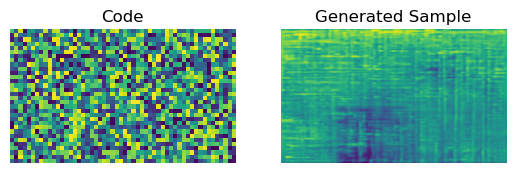

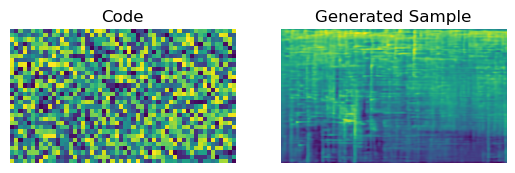

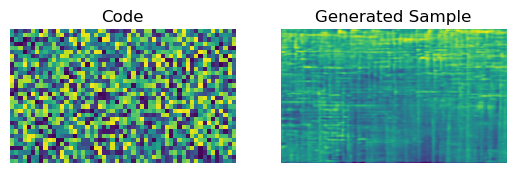

In [15]:
# Perform an embedding lookup.
pretrained_embeddings = vqvae.quantizer.layers[-1].embeddings
priors_ohe = tf.one_hot(priors.astype("int32"), num_embeddings).numpy()
quantized = tf.matmul(
    priors_ohe.astype("float32"), pretrained_embeddings, transpose_b=True
)
quantized = tf.reshape(quantized, (-1, *(32,54,4)))

# Generate novel images.
decoder = vqvae.decoder
generated_samples = decoder.predict(quantized)

for i in range(batch):
    plt.subplot(1, 2, 1)
    plt.imshow(priors[i])
    plt.title("Code")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(generated_samples[i].squeeze() + 0.5)
    plt.title("Generated Sample")
    plt.axis("off")
    plt.show()

In [16]:
generated_samples.shape

(3, 128, 216, 1)

### Testing Music Quality

In [17]:
import librosa
import librosa.display
import IPython.display as ipd

In [19]:
index = 0
S_hat = generated_samples[index,:,:,0]
S_hat = denormalize(S_hat)

In [20]:
sr = 22050
hop_length = 1024
n_fft = hop_length*4

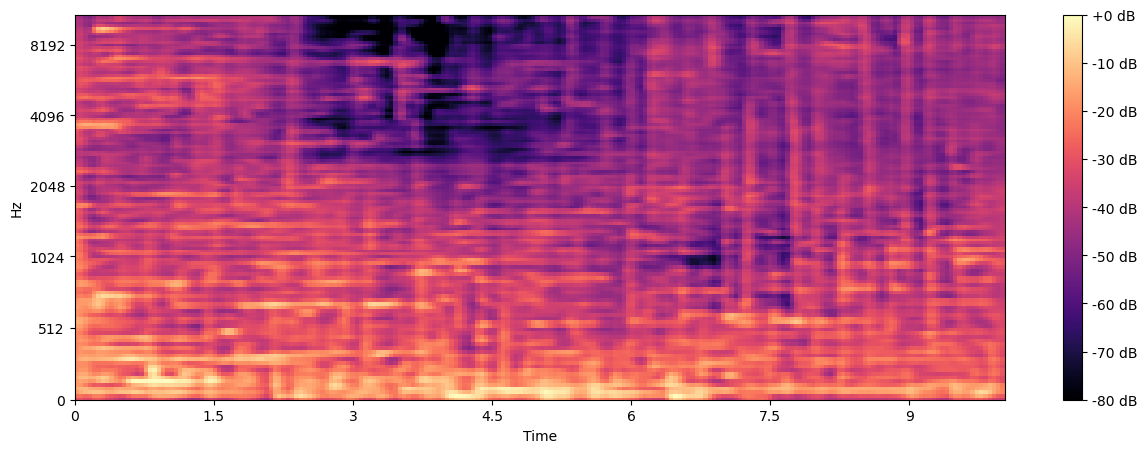

In [21]:
## Recreated
plt.figure(figsize=(15, 5))
librosa.display.specshow(S_hat, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel',cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.show()

In [29]:
output_hat = librosa.feature.inverse.mel_to_audio(librosa.db_to_power(S_hat),sr=sr,n_fft=n_fft,hop_length=hop_length)
ipd.Audio(output_hat, rate=sr)

: 

In [74]:
from PIL import ImageGrab
import cv2

im = ImageGrab.grabclipboard()
im.save('somefile.png','PNG')


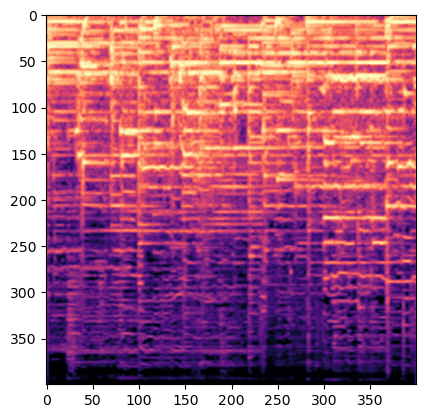

In [75]:
im = cv2.imread('somefile.png',cv2.IMREAD_GRAYSCALE)
plt.imshow(np.array(im).astype(float), cmap='magma')

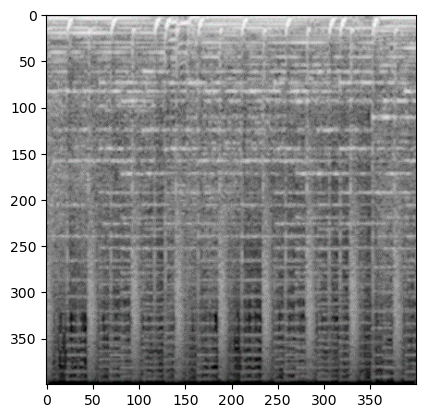

In [46]:
plt.imshow(im)